In [ ]:
import platform
platform.platform()

'Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pandas import read_csv
import datetime
from pandas import concat
import numpy as np
# load data
def parse(x):
	return datetime.datetime.strptime(x, '%Y %m %d %H')

# 첫 주행 날짜
first_date = datetime.datetime.strptime("20220801", "%Y%m%d")
first_date_str = str(first_date)
first_date_str = first_date_str[:first_date_str.find(' ')].replace('-', '')
print(first_date_str)
print(first_date)
# 현재 날짜
now_date  = datetime.datetime.now()

# 받아올 데이터 일수
read_time = str(now_date - first_date)
read_time = int(read_time[:read_time.find(' ')])
print(read_time)

dataset = []

# 역대 환경 데이터를 모두 읽어옴
for i in range(read_time+1):
	read_file_name = str(first_date + datetime.timedelta(days = i))
	read_file_name = read_file_name[:read_file_name.find(' ')].replace('-', '')
	print(read_file_name)
	dataset.append(read_csv('/content/drive/MyDrive/dataset/pollution_data' + '/fake_data_' + read_file_name +'.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse))

dataset = concat([dataset[i] for i in range(len(dataset))], axis=0)
dataset.drop('No', axis=1, inplace=True) 
# manually specify column names
dataset.columns = ['local', 'temp', 'humidity', 'metter']
dataset.index.name = 'date'

print(dataset.head(5)) 
# save to file
dataset.to_csv('/content/drive/MyDrive/dataset/pollution_data/pollution.csv')
print(dataset)

20220801
2022-08-01 00:00:00
22
20220801
20220802
20220803
20220804
20220805
20220806
20220807
20220808
20220809
20220810
20220811
20220812
20220813
20220814
20220815
20220816
20220817
20220818
20220819
20220820
20220821
20220822
20220823
                     local  temp  humidity  metter
date                                              
2022-08-01 09:00:00      1  23.5      38.3       3
2022-08-01 09:00:00      2  23.6      37.0       3
2022-08-01 09:00:00      3  23.8      35.0       3
2022-08-01 09:00:00      4  23.9      34.0       3
2022-08-01 09:00:00      5  23.3      33.5       2
                     local  temp  humidity  metter
date                                              
2022-08-01 09:00:00      1  23.5      38.3       3
2022-08-01 09:00:00      2  23.6      37.0       3
2022-08-01 09:00:00      3  23.8      35.0       3
2022-08-01 09:00:00      4  23.9      34.0       3
2022-08-01 09:00:00      5  23.3      33.5       2
...                    ...   ...       ...     

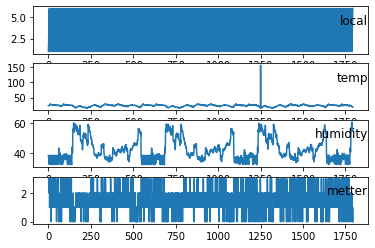

In [ ]:
from matplotlib import pyplot
# load dataset
dataset = read_csv('/content/drive/MyDrive/dataset/pollution_data/pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [ ]:
# prepare data for lstm
from pandas import DataFrame

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	# print(df)
	cols, names = list(), list()
	# 7일 전의 환경 데이터를 input, 7일 후의 환경 데이터를 target으로 설정
	cols.append(df.shift(6*13*7))
	names += [('var%d(t-%d)' % (j+1, 7)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	cols.append(df)
	names += [('var%d(t)' % (j+1)) for j in range(n_vars)]

	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	# drop columns we don't want to predict
	agg.drop(agg.columns[[3,4]], axis=1, inplace=True)
	
	# 구역에 따라  환경데이터를 묶어준다.
	local = agg[['var1(t-7)',  'var2(t-7)',  'var3(t-7)']].values
	local = local.reshape(13*int((local.shape[0]/13/6)),6,3)
	label = agg['var3(t)'].values
	label = label.reshape(13*int((label.shape[0]/13/6)),6)
	return local, label

# load dataset
dataset = read_csv('/content/drive/MyDrive/dataset/pollution_data/pollution.csv', header=0, index_col=0)
values = dataset.drop(['local'], axis = 1).values
# integer encode direction
encoder = LabelEncoder()
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed, target = series_to_supervised(scaled, 1, 1)
print(reframed.shape, target.shape)

(208, 6, 3) (208, 6)


In [ ]:
# split into train and test sets
values = reframed
# 5일치를 학습시킴
n_train_hours = int(values.shape[0]/13/3)*2*13
train_X, train_y = values[:n_train_hours], target[:n_train_hours]
test_X,  test_y  = values[n_train_hours:], target[n_train_hours:]

# reshape input to be 3D [samples, timesteps, features]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(train_X, train_y)

(130, 6, 3) (130, 6) (78, 6, 3) (78, 6)
[[[5.92801645e-02 2.21453190e-01 1.00000000e+00]
  [5.99858835e-02 1.76470518e-01 1.00000000e+00]
  [6.13973066e-02 1.07266426e-01 1.00000000e+00]
  [6.21030256e-02 7.26642609e-02 1.00000000e+00]
  [5.78687266e-02 5.53632975e-02 6.66666687e-01]
  [5.71630225e-02 1.03806257e-02 6.66666687e-01]]

 [[6.63373247e-02 2.21453190e-01 1.00000000e+00]
  [7.33944997e-02 1.76470518e-01 3.33333343e-01]
  [8.25688019e-02 1.07266426e-01 6.66666687e-01]
  [8.32745209e-02 7.26642609e-02 3.33333343e-01]
  [8.60973820e-02 5.53632975e-02 3.33333343e-01]
  [9.24488381e-02 1.03806257e-02 3.33333343e-01]]

 [[1.04446016e-01 2.21453190e-01 1.00000000e+00]
  [9.66831222e-02 1.76470518e-01 3.33333343e-01]
  [8.25688019e-02 1.07266426e-01 6.66666687e-01]
  [8.32745209e-02 7.26642609e-02 3.33333343e-01]
  [8.04516599e-02 5.53632975e-02 0.00000000e+00]
  [7.69230798e-02 1.03806257e-02 3.33333343e-01]]

 ...

 [[2.39943489e-02 6.29757643e-01 3.33333343e-01]
  [1.69371888e-02

Epoch 1/15
20/20 - 2s - loss: 0.4729 - accuracy: 0.1197 - val_loss: 0.3337 - val_accuracy: 0.1538 - 2s/epoch - 97ms/step
Epoch 2/15
20/20 - 0s - loss: 0.3887 - accuracy: 0.1197 - val_loss: 0.2621 - val_accuracy: 0.1538 - 113ms/epoch - 6ms/step
Epoch 3/15
20/20 - 0s - loss: 0.2986 - accuracy: 0.1197 - val_loss: 0.2484 - val_accuracy: 0.1538 - 114ms/epoch - 6ms/step
Epoch 4/15
20/20 - 0s - loss: 0.2368 - accuracy: 0.1111 - val_loss: 0.2060 - val_accuracy: 0.8462 - 113ms/epoch - 6ms/step
Epoch 5/15
20/20 - 0s - loss: 0.1973 - accuracy: 0.7436 - val_loss: 0.1703 - val_accuracy: 0.8462 - 140ms/epoch - 7ms/step
Epoch 6/15
20/20 - 0s - loss: 0.1802 - accuracy: 0.7436 - val_loss: 0.1555 - val_accuracy: 0.8462 - 142ms/epoch - 7ms/step
Epoch 7/15
20/20 - 0s - loss: 0.1778 - accuracy: 0.7436 - val_loss: 0.1494 - val_accuracy: 0.8462 - 143ms/epoch - 7ms/step
Epoch 8/15
20/20 - 0s - loss: 0.1748 - accuracy: 0.7436 - val_loss: 0.1485 - val_accuracy: 0.8462 - 120ms/epoch - 6ms/step
Epoch 9/15
20/20 -

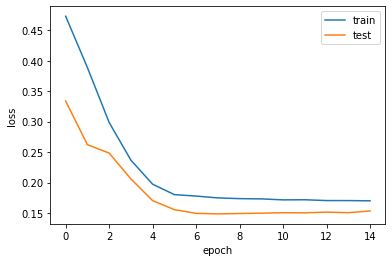

In [ ]:

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import BatchNormalization


# design network

model = Sequential()
model.add(LSTM(25, input_shape=(train_X.shape[1], train_X.shape[2]), activation="softsign", recurrent_activation="elu"))
model.add(Dense(5))
model.add(Dense(16))
model.add(Dense(8))
model.add(Dense(6))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y, epochs=15 , batch_size=6, validation_data=(test_X, test_y),
                    verbose=2, shuffle=False, validation_split = 0.1)
# plot historyz
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
from sklearn.metrics import mean_squared_error
# # make a prediction
prediction = model.predict(test_X)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(test_y, prediction))
print('Test RMSE: %.3f' % rmse)

loss, acc = model.evaluate(test_X, test_y, batch_size=1)
print("loss : ", loss)
print("acc : " , acc)

# R2 구하기
from sklearn.metrics import r2_score
r2_y_predict = r2_score(test_y, prediction)
print("R2 : ", r2_y_predict)

Test RMSE: 0.229
78/78 [==============================] - 0s 2ms/step - loss: 0.1728 - accuracy: 0.8205
loss :  0.17282509803771973
acc :  0.8205128312110901
R2 :  0.05031317535547841


In [ ]:

# 다음 날의 주행을 예측하기 위해서는 현재로부터 6일 전의 데이터를 넣고 추출시켜야 함
tst_tim = str(datetime.datetime.now() - datetime.timedelta(days = 6))
tst_tim = tst_tim[:tst_tim.find(' ')].replace('-', '')
print(tst_tim)

predic_data = []
predic_data.append(read_csv('/content/drive/MyDrive/dataset/pollution_data' + '/fake_data_' + tst_tim +'.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse))


predic_data = concat([predic_data[i] for i in range(len(predic_data))], axis=0)
predic_data.drop('No', axis=1, inplace=True) 
# manually specify column names
predic_data.columns = ['local', 'temp', 'humidity', 'metter']
predic_data.index.name = 'date'

print(predic_data.head(5)) 

predic_values = predic_data.drop(['local'], axis = 1).values
# integer encode direction
encoder = LabelEncoder()
# ensure all data is float
predic_values = predic_values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
predic_scaled = scaler.fit_transform(predic_values)
# frame as supervised learning
predic_scaled = predic_scaled.reshape(13,6,3)
predic = np.array(model.predict(predic_scaled))
print(predic_scaled)

20220817
                     local   temp  humidity  metter
date                                               
2022-08-17 09:00:00      1   15.3      58.8       3
2022-08-17 09:00:00      2   15.6      58.9       3
2022-08-17 09:00:00      3  156.8      58.4       2
2022-08-17 09:00:00      4   15.9      56.5       2
2022-08-17 09:00:00      5   15.4      57.1       1
[[[1.4114305e-03 9.7604775e-01 1.0000000e+00]
  [3.5285801e-03 9.8203588e-01 1.0000000e+00]
  [1.0000000e+00 9.5209575e-01 6.6666669e-01]
  [5.6457222e-03 8.3832335e-01 6.6666669e-01]
  [2.1171421e-03 8.7425137e-01 3.3333334e-01]
  [0.0000000e+00 1.0000000e+00 3.3333334e-01]]

 [[6.3514411e-03 9.2814350e-01 3.3333334e-01]
  [7.0571601e-03 9.1017962e-01 3.3333334e-01]
  [1.4820039e-02 9.3413162e-01 6.6666669e-01]
  [1.5525751e-02 7.9640698e-01 0.0000000e+00]
  [2.4700068e-02 7.4251485e-01 0.0000000e+00]
  [2.6111491e-02 7.1257496e-01 3.3333334e-01]]

 [[3.2462947e-02 8.3832335e-01 6.6666669e-01]
  [2.6817210e-02 7.844309

# 정화 시간 match
- softmax 함수를 구현
- predict로 구한 다음 날의 오염도를 sftmax함수에 넣고 주행 시간 구하기

In [ ]:
#softmax function 
def softmax(a):
  exp_a = np.exp(a)
  sum_exp_a = np.sum(exp_a)
  y = exp_a / sum_exp_a
  return y

In [ ]:
# results clean_time
clean_time = np.array([])
local = np.array([])
for i in predic:
  clean_time = np.append(clean_time, [int(round(i)) for i in (softmax(i)*60)])
  local = np.append(local, np.arange(1,7))
clean_time = clean_time.reshape(clean_time.shape[0],1)
local      = local.reshape(local.shape[0],1)
scadul     = np.concatenate((local, clean_time), axis = 1)
columns    = [ 'local', 'stay_time']
send_df    = DataFrame(scadul, columns = columns)
send_df    = send_df.set_index('local')
print(send_df)
send_df.to_csv('/content/drive/MyDrive/dataset/pollution_data/send.csv')

       stay_time
local           
1.0         13.0
2.0         10.0
3.0         10.0
4.0          9.0
5.0          8.0
...          ...
2.0         10.0
3.0         10.0
4.0          9.0
5.0          9.0
6.0          9.0

[78 rows x 1 columns]


In [ ]:
# compare prediction and db
tomorrow_time = str(datetime.datetime.now() + datetime.timedelta(days = 1))
tomorrow_time = tomorrow_time[:tomorrow_time.find(' ')].replace('-', '')
tomorrow_data=np.array([])
tomorrow_data = np.append(tomorrow_data,read_csv('/content/drive/MyDrive/dataset/pollution_data' + '/fake_data_' + tomorrow_time +'.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)['metter'].values)
tomorrow_data = tomorrow_data.reshape(int(tomorrow_data.shape[0]/6),6)


real_clean_time = np.array([])
for i in tomorrow_data:
  real_clean_time = np.append(real_clean_time, [int(round(i)) for i in (softmax(i)*60)])
  
real_clean_time = real_clean_time.reshape(real_clean_time.shape[0],1)
rmse = np.sqrt(mean_squared_error(real_clean_time, clean_time))

#예측 결과 100% 맞음
#다만, 현재 예측한 결과는 train_data에 이미 있는 값임
time = np.concatenate((real_clean_time, clean_time), axis = 1)
print(time)
print('Test RMSE: %.3f' % rmse)


[[ 7. 13.]
 [20. 10.]
 [20. 10.]
 [ 7.  9.]
 [ 3.  8.]
 [ 3.  9.]
 [ 4. 11.]
 [28. 10.]
 [10. 10.]
 [10. 10.]
 [ 4. 10.]
 [ 4. 10.]
 [31. 11.]
 [12. 10.]
 [ 4. 10.]
 [ 4. 10.]
 [ 4. 10.]
 [ 4. 10.]
 [ 6. 12.]
 [17. 10.]
 [ 6. 10.]
 [ 6.  9.]
 [ 6.  9.]
 [17.  9.]
 [15. 12.]
 [ 5. 10.]
 [ 5. 10.]
 [15.  9.]
 [ 5.  9.]
 [15.  9.]
 [ 9. 12.]
 [25. 10.]
 [ 9. 10.]
 [ 3.  9.]
 [ 9.  9.]
 [ 3.  9.]
 [ 8. 12.]
 [ 8. 10.]
 [23. 10.]
 [ 8.  9.]
 [ 8.  9.]
 [ 3.  9.]
 [ 3. 13.]
 [ 9. 11.]
 [25. 10.]
 [ 9.  9.]
 [ 3.  9.]
 [ 9.  9.]
 [23. 12.]
 [ 8. 10.]
 [ 8. 10.]
 [ 3.  9.]
 [ 8.  9.]
 [ 8.  9.]
 [15. 13.]
 [15. 10.]
 [ 6. 10.]
 [ 6.  9.]
 [ 2.  9.]
 [15.  9.]
 [23. 12.]
 [ 8. 10.]
 [ 8. 10.]
 [ 3.  9.]
 [ 8.  9.]
 [ 8.  9.]
 [25. 12.]
 [ 9. 10.]
 [ 3. 10.]
 [ 9.  9.]
 [ 9.  9.]
 [ 3.  9.]
 [20. 12.]
 [20. 10.]
 [ 7. 10.]
 [ 7.  9.]
 [ 3.  9.]
 [ 3.  9.]]
Test RMSE: 6.699
